### Import lib

In [1]:
import pandas as pd 
import numpy as np

from sklearn.preprocessing import LabelEncoder


import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 

## Metrics
import sklearn.metrics as metrics

from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


### load data

In [2]:
data = pd.read_csv("blogtext.csv")

In [3]:
### Filter out the topic by ( indUnk,Student,Technology ) since running for all the topic takes long time
data = data.query("topic in ['indUnk','Student','Technology']")

In [4]:
data.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
74,3539003,female,14,indUnk,Aries,"07,June,2004",O= optimist P= pessimist My...


In [5]:
data.columns

Index(['id', 'gender', 'age', 'topic', 'sign', 'date', 'text'], dtype='object')

### Exploratory Data Analysis

In [6]:
print("Is any missing values",data.isna().sum().sum())

print("Shape of the data",data.shape)

Is any missing values 0
Shape of the data (446973, 7)


#### Gender

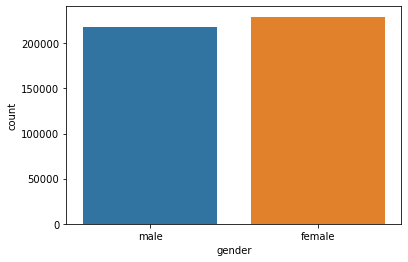

In [7]:
# print('Unique value')
# #print(data.gender.unique())
# print(data.gender.value_counts())

sns.countplot(data=data,x="gender")

- distribution of Male and Female data is almost same

#### Age

In [8]:
print('Unique value')
#print(data.gender.unique())
#data.sort_values("age",inplace=True)
print(data.age.value_counts(sort=False))

Unique value
13    11055
14    22919
15    35291
16    63862
17    65446
23    42528
24    48422
25    35079
26    27362
27    27248
33     7184
34    14841
35    11857
36     6228
37     4777
38     5374
39     2873
40     3110
41     1776
42     1744
43     1585
44      910
45     1810
46      718
47      707
48     2267
Name: age, dtype: int64


 - data distribution of age 13 - 17 , 23 - 27 ,33 - 48
 - Age can be converted to categorical value ( 10s , 20s & 30s )  

In [9]:
def age_to_categorical(x):
    if x >=13 and x <=17:
        return "10s"
    elif x >=23 and x <=27:
        return "20s"
    else:
        return "30s"

data["age_impu"] = data["age"].apply(age_to_categorical)

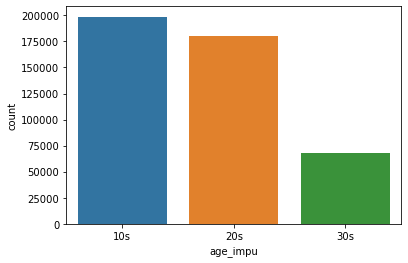

In [10]:
sns.countplot(data=data,x="age_impu")

- data distribution for 10s are high when compare to 20s and 30s

#### topic

In [11]:
data["topic"].value_counts()

indUnk        251015
Student       153903
Technology     42055
Name: topic, dtype: int64

#### sign

In [12]:
data["sign"].value_counts()

Aries          45172
Cancer         44621
Taurus         42507
Libra          40787
Virgo          39697
Leo            36357
Scorpio        36138
Pisces         34163
Capricorn      32373
Sagittarius    32062
Gemini         31965
Aquarius       31131
Name: sign, dtype: int64

#### Delete id and age

In [13]:
## Delete ID and date
data.drop(["id","date"],inplace=True,axis=1)
data.columns

Index(['gender', 'age', 'topic', 'sign', 'text', 'age_impu'], dtype='object')

#### Target

In [14]:
data["Target"] = data["gender"].map(str) + data["age_impu"].map(str)  + data["topic"].map(str)+data["sign"].map(str)

In [15]:
#label Encoding on Target
labelEncoding = LabelEncoder()
data["Target_imp"] = labelEncoding.fit_transform(data["Target"])

In [16]:
data["Target_imp"].describe()

count    446973.000000
mean         91.320565
std          59.645731
min           0.000000
25%          35.000000
50%          98.000000
75%         140.000000
max         204.000000
Name: Target_imp, dtype: float64

In [17]:
data["Target_imp"].value_counts()

55     10371
54      9512
6       9029
170     6767
111     6619
       ...  
16         7
71         5
175        4
15         4
75         2
Name: Target_imp, Length: 205, dtype: int64

### Text pre-processing
 - convert to lowercase and remove punctuations and characters and then strip
 - Tokenize (convert from string to list)
 - remove Stopwords
 - Stemming (remove -ing, -ly, ...)
 - Lemmatisation (convert the word into root word)

In [18]:
def text_processing(text, lst_stopwords,flg_stemm=True, flg_lemm=True):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
    #print(lst_text)           
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text


lst_stopwords = nltk.corpus.stopwords.words("english")
data["text_processed"] = data["text"].apply(lambda x:text_processing(x,lst_stopwords,True,True))


In [19]:
data.head()

,gender,age,topic,sign,text,age_impu,Target,Target_imp,text_processed
0,male,15,Student,Leo,"Info has been found (+/- 100 pages,...",10s,male10sStudentLeo,105,info found 100 page 45 mb pdf file wait until ...
1,male,15,Student,Leo,These are the team members: Drewe...,10s,male10sStudentLeo,105,team member drew van der laag urllink mail rui...
2,male,15,Student,Leo,In het kader van kernfusie op aarde...,10s,male10sStudentLeo,105,het kader van kernfusi op aard maak je eigen w...
3,male,15,Student,Leo,testing!!! testing!!!,10s,male10sStudentLeo,105,test test
74,female,14,indUnk,Aries,O= optimist P= pessimist My...,10s,female10sindUnkAries,18,optimist p pessimist argument p nooooo stop th...


### Train - Test Split

In [41]:
X = data["text_processed"]
y = data["Target"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)

print("X_train Shape",X_train.shape)
print("y_train Shape",y_train.shape)

print("X_test Shape",X_test.shape)
print("y_test Shape",y_test.shape)

X_train Shape (357578,)
y_train Shape (357578,)
X_test Shape (89395,)
y_test Shape (89395,)


### Approach 1 - Using BoW

In [42]:
bow_vector = CountVectorizer(max_features=10000, ngram_range=(1,2))

In [43]:
## pipeline
bow_model = Pipeline([("vectorizer", bow_vector),  
                           ("classifier", MultinomialNB())])
## train classifier
bow_model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_features=10000, ngram_range=(1, 2))),
                ('classifier', MultinomialNB())])

In [44]:
predicted = bow_model.predict(X_test)
predicted_prob = bow_model.predict_proba(X_test)

In [32]:
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
print("Accuracy:",  round(accuracy,2))

print(metrics.classification_report(y_test, predicted))

Accuracy: 0.15
                                precision    recall  f1-score   support

      female10sStudentAquarius       0.26      0.39      0.31      1010
         female10sStudentAries       0.18      0.17      0.17      1157
        female10sStudentCancer       0.17      0.11      0.14       739
     female10sStudentCapricorn       0.11      0.10      0.10       925
        female10sStudentGemini       0.13      0.09      0.11       748
           female10sStudentLeo       0.12      0.10      0.11      1061
         female10sStudentLibra       0.13      0.32      0.19      1819
        female10sStudentPisces       0.16      0.06      0.09       941
   female10sStudentSagittarius       0.16      0.19      0.18       781
       female10sStudentScorpio       0.13      0.10      0.12       828
        female10sStudentTaurus       0.09      0.16      0.12       763
         female10sStudentVirgo       0.19      0.16      0.18      1076
      female10sTechnologyLibra       0.00      0

### Approach 2 -  Tf-Idf

In [59]:
tfidf_vector = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
## pipeline
tfidf_model = Pipeline([("vectorizer", tfidf_vector),  
                           ("classifier", MultinomialNB())])
## train classifier
tfidf_model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=1000, ngram_range=(1, 2))),
                ('classifier', MultinomialNB())])

In [57]:
predicted = tfidf_model.predict(X_test)
predicted_prob = tfidf_model.predict_proba(X_test)

In [58]:
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
print("Accuracy:",  round(accuracy,2))

print(metrics.classification_report(y_test, predicted))

Accuracy: 0.12
                                precision    recall  f1-score   support

      female10sStudentAquarius       0.45      0.31      0.37      1010
         female10sStudentAries       0.18      0.14      0.16      1157
        female10sStudentCancer       0.32      0.03      0.06       739
     female10sStudentCapricorn       0.22      0.16      0.18       925
        female10sStudentGemini       0.30      0.02      0.03       748
           female10sStudentLeo       0.24      0.09      0.13      1061
         female10sStudentLibra       0.06      0.68      0.11      1819
        female10sStudentPisces       0.34      0.06      0.10       941
   female10sStudentSagittarius       0.61      0.05      0.10       781
       female10sStudentScorpio       0.26      0.03      0.05       828
        female10sStudentTaurus       0.12      0.10      0.11       763
         female10sStudentVirgo       0.23      0.13      0.17      1076
      female10sTechnologyLibra       0.00      0